In [13]:
import matplotlib.pyplot as plt
import os
import glob
import natsort
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("tf version =",tf.__version__)
from tensorflow.keras.models import Model
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Draw, MolFromSmarts
import cv2

import umap
import hdbscan
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize

tf version = 2.2.0-dev20200501


In [3]:
pickle_in = open('ESOL_random.pickle','rb')
ESOL = pickle.load(pickle_in)

ESOL.head()

Compound ID  ESOL predicted log solubility in mols per litre  \
164                RTI 3                                           -3.049   
907           2,4',5-PCB                                           -5.762   
386        aminothiazole                                           -1.226   
221   2,4-Dinitrotoluene                                           -2.604   
1069     o-Methoxyphenol                                           -1.941   

      Minimum Degree  Molecular Weight  Number of H-Bond Donors  \
164                1           255.277                        1   
907                1           257.547                        0   
386                1           100.146                        1   
221                1           182.135                        0   
1069               1           124.139                        1   

      Number of Rings  Number of Rotatable Bonds  Polar Surface Area  \
164                 3                          0               68.45   
907                 2                          1                0.00   
386                 1                          0               38.91   
221                 1                          2               86.28   
1069                1                          1               29.46   

      measured log solubility in mols per litre  \
164                                      -3.043   
907                                      -6.250   
386                                      -0.360   
221                                      -2.820   
1069                                     -1.960   

                                   smiles  
164   O2c1cc(C)ccc1N(C)C(=O)c3cc(N)cnc23   
907           Clc1ccc(cc1)c2cc(Cl)ccc2Cl   
386                             Nc1nccs1   
221             Cc1ccc(cc1N(=O)=O)N(=O)=O  
1069                          COc1ccccc1O

50.0 %
100.0 %
(1128, 28, 28, 1)


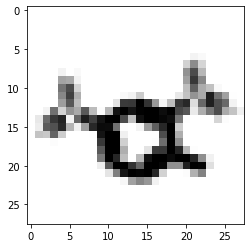

In [6]:
n = 0
n_max = len(ESOL)

gimg_list = []
y = []

while n < n_max:
    
    smi = ESOL.iloc[n,9]
    y.append(ESOL.iloc[n,8])

    size = (28,28)
    ipath = "ESOL_img/" + str(n) + ".png"

    mol = Chem.MolFromSmiles(smi)
    Draw.MolToImageFile(mol,ipath,size = size)
    
    img = cv2.imread(ipath)
    
    gimg_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
          
    os.remove(ipath)
    
    n += 1

    p = (n/n_max)*100
  
    if p == 10 or p==20 or p==30 or p==40 or p==50 or p==60 or p==70 or p==80 or p==90 or p==100:
        print (str(p) + " %")
  
  

gimg_array = (np.array(gimg_list)/255)

X_train = gimg_array.reshape(-1, size[0], size[1],1)
y_train = np.array(y)
del(gimg_list)
del(gimg_array)

print(X_train.shape)
plt.imshow(X_train[3].reshape(size),cmap="gray")
plt.show()

In [109]:
autoencoder = keras.models.load_model('autoencoder28x28.1')
for layer in autoencoder.layers:
    layer.trainable = False

print(autoencoder.summary())

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 4, 4, 8)           0  

In [110]:
intermediate_layer_model = Model(inputs = autoencoder.input, outputs = autoencoder.layers[6].output)
encoder_output = intermediate_layer_model.predict(X_train)

d1, d2, d3, d4 = encoder_output.shape

encoder_output_flatten = encoder_output.reshape((d1, d2*d3*d4))

encoder_output_flatten.shape

(1128, 128)

In [111]:
# Scaling the data to bring all the attributes to a comparable level 
scaler = StandardScaler() 
encoded_scaled = scaler.fit_transform(encoder_output_flatten)
# Normalizing the data so that  
# the data approximately follows a Gaussian distribution 
encoded_normalized = normalize(encoded_scaled)

In [118]:
reducer = umap.UMAP(n_neighbors = 20, min_dist = 0.05)
umaped = reducer.fit_transform(encoded_normalized)
umaped.shape

(1128, 2)

In [119]:
umaped = pd.DataFrame(umaped) 
umaped.columns = ['P1', 'P2'] 
print(umaped.head())
len(umaped)

         P1        P2
0  7.187241  2.894720
1  7.813324  4.317715
2  2.851623  7.038013
3  5.348102  3.587011
4  4.611695  4.381637


1128

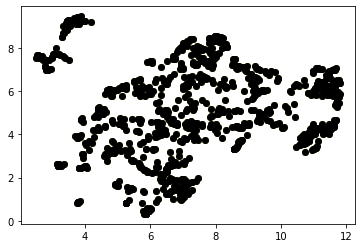

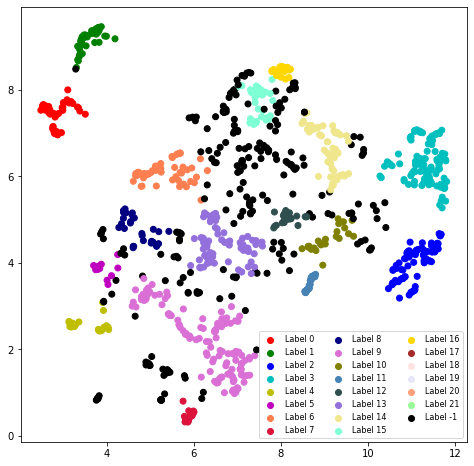

In [124]:
hdb = hdbscan.HDBSCAN(min_cluster_size = 18, min_samples = 12).fit(umaped) #18,6
labels1 = hdb.labels_


colours1 = {} 
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[6] = 'coral'
colours1[7] = 'crimson'
colours1[8] = 'navy'
colours1[9] = 'orchid'
colours1[10] = 'olive'
colours1[11] = 'steelblue'
colours1[12] = 'darkslategrey'
colours1[13] = 'mediumpurple'
colours1[14] = 'khaki'
colours1[15] = 'aquamarine'
colours1[16] = 'gold'
colours1[17] = 'brown'
colours1[18] = 'mistyrose'
colours1[19] = 'lavender'
colours1[20] = 'lightsalmon'
colours1[21] = 'palegreen'
colours1[-1] = 'k'


cvec = [colours1[label] for label in labels1] 
colors = ['r', 'g', 'b', 'c', 'y', 'm','coral', 'crimson', 'navy','orchid','olive','steelblue','darkslategrey',
          'mediumpurple','khaki','aquamarine','gold','brown','mistyrose','lavender','lightsalmon','palegreen', 'k' ] 

r = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[0]) 
g = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[1])  
b = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[2]) 
c = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[3]) 
y = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[4])  
m = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[5])
coral = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[6])
crimson = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[7])
navy = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[8])
orchid = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[9])
olive = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[10])

steelblue = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[11])
darkslategrey = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[12])

mediumpurple = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[13])
khaki = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[14])

aquamarine = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[15])

gold = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[16])
brown = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[17])
mistyrose = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[18])
lavender = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[19])
lightsalmon = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[20])
palegreen = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[21])

k = plt.scatter( 
		umaped['P1'], umaped['P2'], marker ='o', color = colors[-1]) 

plt.figure(figsize =(8, 8)) 
plt.scatter(umaped['P1'], umaped['P2'], c = cvec) 
plt.legend((r, g, b, c, y, m,coral,crimson,navy,orchid,olive,steelblue,darkslategrey,mediumpurple,khaki,aquamarine,gold,brown,mistyrose,lavender,lightsalmon,palegreen, k), 
		('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4',
			'Label 5','Label 6','Label 7','Label 8','Label 9','Label 10','Label 11','Label 12','Label 13','Label 14',
         'Label 15','Label 16','Label 17','Label 18','Label 19','Label 20','Label 21','Label -1'), 
		scatterpoints = 1, 
		loc ='best', 
		ncol = 3, 
		fontsize = 8) 
plt.show() 




In [130]:
imgs = X_train.reshape(-1,28,28)
sortindx = np.argsort(labels1)
values = labels1[sortindx]

In [135]:
max(labels1)
labels1[labels1 == 16] = 15

pickle_out = open('labels1_hdbscan_final.pickle', 'wb')
pickle.dump(labels1, pickle_out)
pickle_out.close()

pickle_out = open('umaped_hdbscan_final.pickle', 'wb')
pickle.dump(umaped, pickle_out)
pickle_out.close()

In [1]:
for d in range(max(labels1)+1):

    # using enumerate() + next() to find index of 
    # first element just greater than 0.6  
    res = next(x for x, val in enumerate(values) 
                                  if val == d)
  
    # printing result 
    print ("first element indedx d : " + str(d)+ ","
                                           + str(res))

    i = res
    fig, axs = plt.subplots(3,4,figsize=(10, 10))
    fig.suptitle('label ' + str(d))
    axs[0,0].imshow(imgs[sortindx[i]],cmap="gray")
    axs[0,1].imshow(imgs[sortindx[i+1]],cmap="gray")
    axs[1,0].imshow(imgs[sortindx[i+2]],cmap="gray")
    axs[1,1].imshow(imgs[sortindx[i+3]],cmap="gray")
    axs[2,0].imshow(imgs[sortindx[i+4]],cmap="gray")
    axs[2,1].imshow(imgs[sortindx[i+5]],cmap="gray")
    axs[0,2].imshow(imgs[sortindx[i+6]],cmap="gray")
    axs[1,2].imshow(imgs[sortindx[i+7]],cmap="gray")
    axs[2,2].imshow(imgs[sortindx[i+8]],cmap="gray")
    axs[0,3].imshow(imgs[sortindx[i+9]],cmap="gray")
    axs[1,3].imshow(imgs[sortindx[i+10]],cmap="gray")
    axs[2,3].imshow(imgs[sortindx[i+11]],cmap="gray")
    plt.show
    plt.savefig('hdbscan_final_15,16_merged_label_'+str(d))

NameError: name 'labels1' is not defined

In [7]:
pickle_in = open('labels1_hdbscan_final.pickle','rb')
labels1 = pickle.load(pickle_in)

pickle_in = open('umaped_hdbscan_final.pickle','rb')
umaped = pickle.load(pickle_in)

imgs = X_train.reshape(-1,28,28)
sortindx = np.argsort(labels1)
values = labels1[sortindx]

first element indedx d : 0,243
first element indedx d : 1,292
first element indedx d : 2,340
first element indedx d : 3,420
first element indedx d : 4,534
first element indedx d : 5,571
first element indedx d : 6,593
first element indedx d : 7,649
first element indedx d : 8,673
first element indedx d : 9,708
first element indedx d : 10,843
first element indedx d : 11,868
first element indedx d : 12,891
first element indedx d : 13,916
first element indedx d : 14,999
first element indedx d : 15,1059


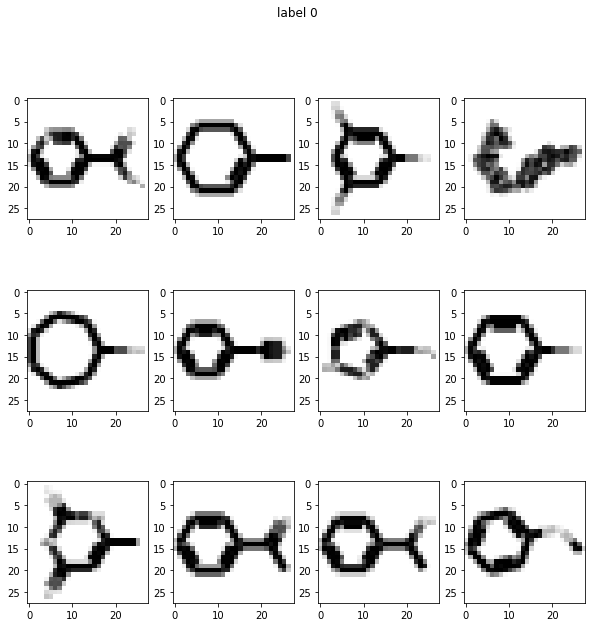

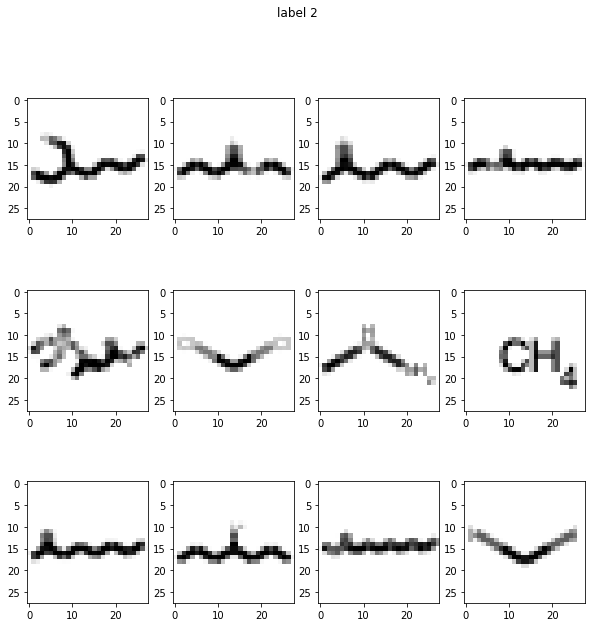

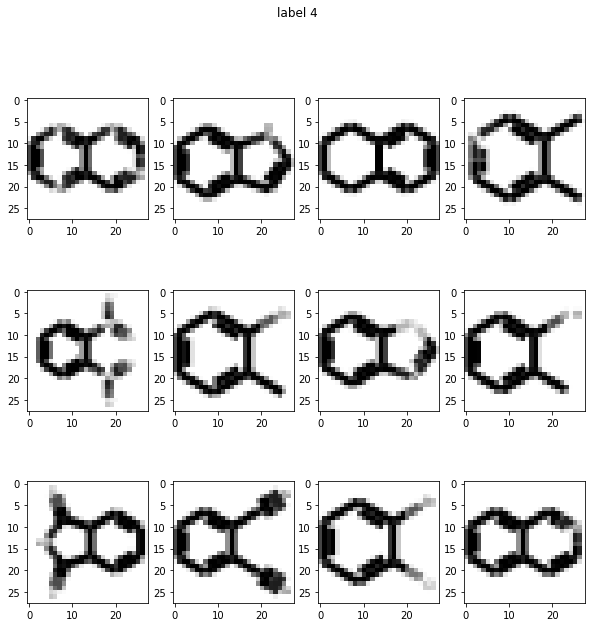

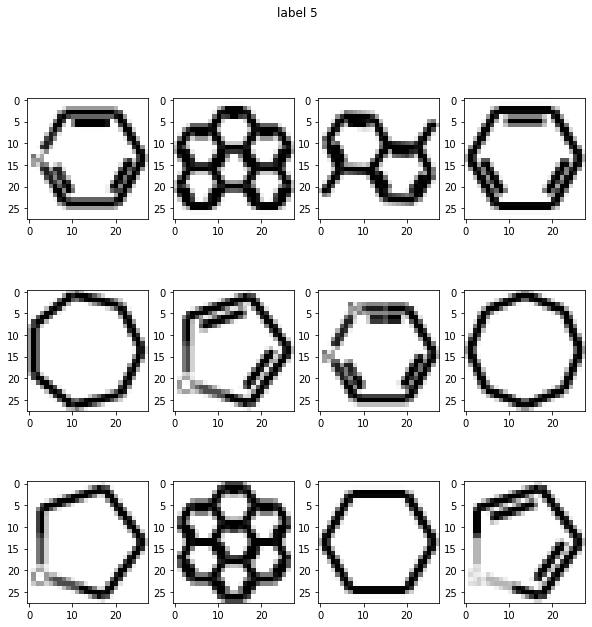

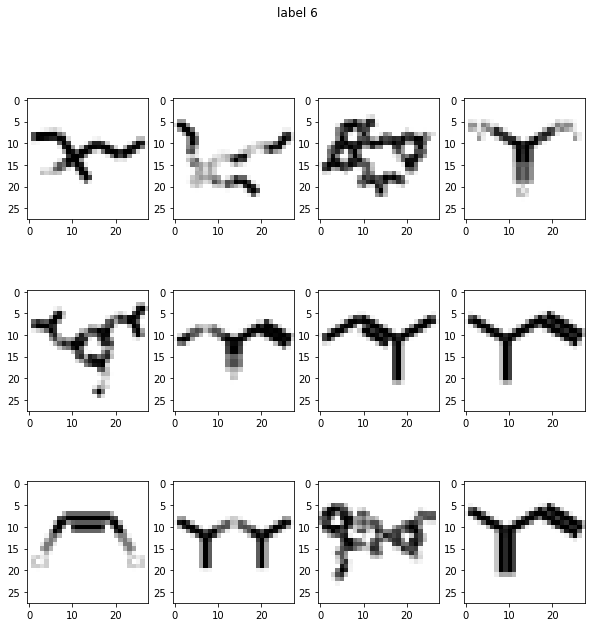

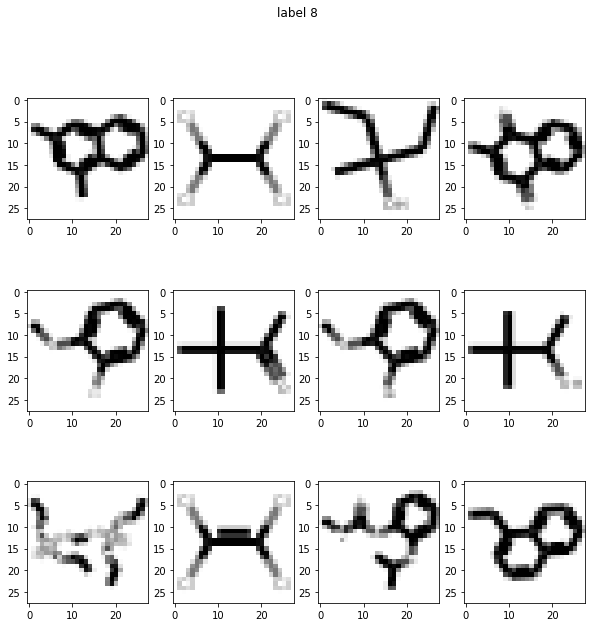

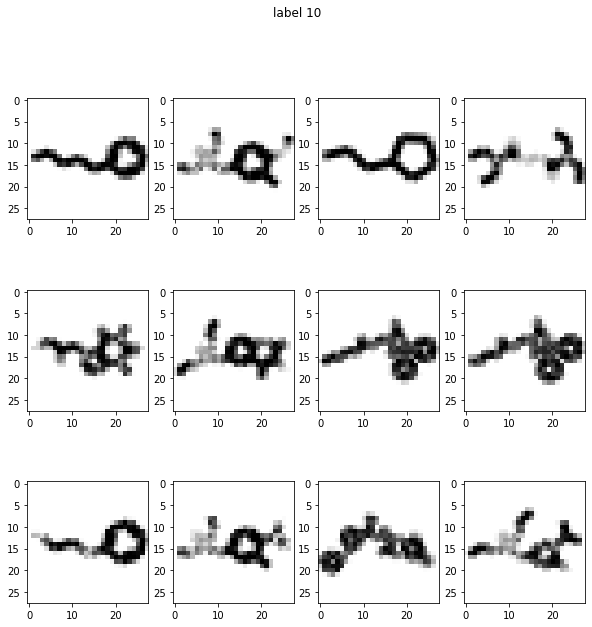

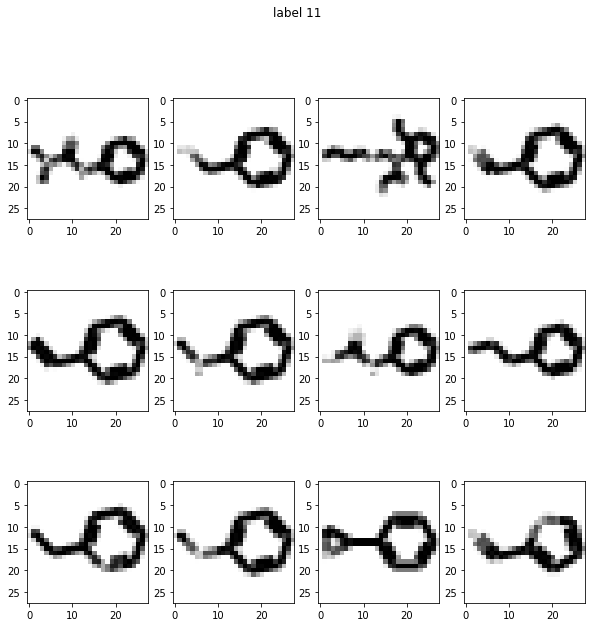

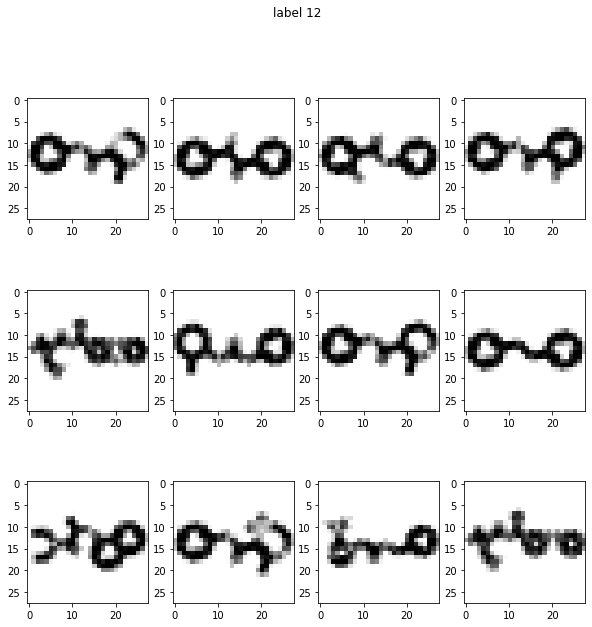

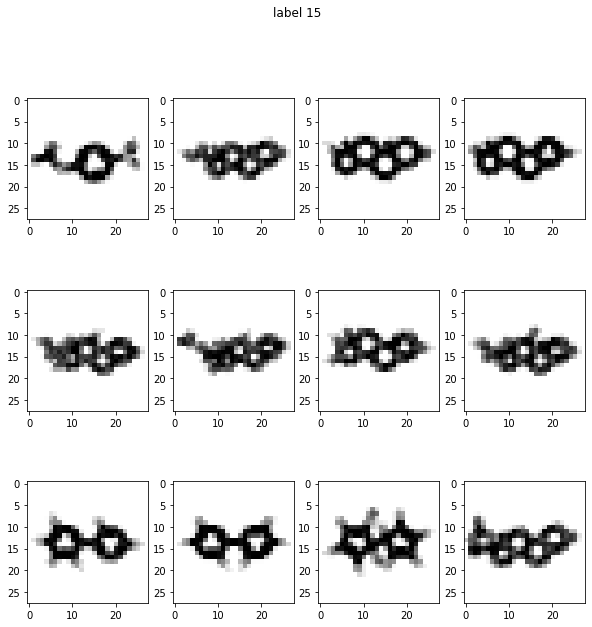

In [8]:
for d in range(max(labels1)+1):

    # using enumerate() + next() to find index of 
    # first element just greater than 0.6  
    res = next(x for x, val in enumerate(values) 
                                  if val == d)
  
    # printing result 
    print ("first element indedx d : " + str(d)+ ","
                                           + str(res))

    i = res
    fig, axs = plt.subplots(3,4,figsize=(10, 10))
    fig.suptitle('label ' + str(d))
    axs[0,0].imshow(imgs[sortindx[i]],cmap="gray")
    axs[0,1].imshow(imgs[sortindx[i+1]],cmap="gray")
    axs[1,0].imshow(imgs[sortindx[i+2]],cmap="gray")
    axs[1,1].imshow(imgs[sortindx[i+3]],cmap="gray")
    axs[2,0].imshow(imgs[sortindx[i+4]],cmap="gray")
    axs[2,1].imshow(imgs[sortindx[i+5]],cmap="gray")
    axs[0,2].imshow(imgs[sortindx[i+6]],cmap="gray")
    axs[1,2].imshow(imgs[sortindx[i+7]],cmap="gray")
    axs[2,2].imshow(imgs[sortindx[i+8]],cmap="gray")
    axs[0,3].imshow(imgs[sortindx[i+9]],cmap="gray")
    axs[1,3].imshow(imgs[sortindx[i+10]],cmap="gray")
    axs[2,3].imshow(imgs[sortindx[i+11]],cmap="gray")
    plt.show

In [10]:
values

array([-1, -1, -1, ..., 15, 15, 15])

In [11]:
sortindx

array([   0,  269,  966, ...,  915,  139, 1071])

In [95]:
# using enumerate() + next() to find index of   
d = 0
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 0
Mw mean 161.12403916608332
Mw std 137.65293512905455
HA mean 2.6666666666666665
HA std 2.9953667926019047
RS mean 1.3541666666666667
RS std 1.4214075086179738
AR mean 0.75
AR std 0.47871355387816905
48


In [96]:
# using enumerate() + next() to find index of   
d = 1
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 1
Mw mean 166.93804234459571
Mw std 60.23743553626743
HA mean 2.765957446808511
HA std 1.9264427139430123
RS mean 1.0212765957446808
RS std 0.14430489325798446
AR mean 0.8297872340425532
AR std 0.3758196113330999
47


In [97]:
# using enumerate() + next() to find index of   
d = 2
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 2
Mw mean 141.59241180754427
Mw std 64.57383357209947
HA mean 2.4050632911392404
HA std 2.269885333309588
RS mean 0.0759493670886076
RS std 0.3090267244489545
AR mean 0.05063291139240506
AR std 0.21924693766694647
79


In [98]:
# using enumerate() + next() to find index of   
d = 3
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 3
Mw mean 128.46523837911502
Mw std 67.89198510895474
HA mean 1.3716814159292035
HA std 1.6085759670798956
RS mean 0.035398230088495575
RS std 0.22769345717289569
AR mean 0.02654867256637168
AR std 0.2086694888947185
113


In [99]:
# using enumerate() + next() to find index of   
d = 4
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 4
Mw mean 142.84849400599998
Mw std 43.24796496976644
HA mean 1.6388888888888888
HA std 1.2942775285801937
RS mean 1.4722222222222223
RS std 0.4992277987669841
AR mean 1.2222222222222223
AR std 0.5826715823167509
36


In [100]:
# using enumerate() + next() to find index of   
d = 5
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 5
Mw mean 116.87936980819048
Mw std 69.37717142816928
HA mean 0.42857142857142855
HA std 0.6598288790738581
RS mean 1.8571428571428572
RS std 1.7804684853180874
AR mean 1.3333333333333333
AR std 2.03149800073348
21


In [101]:
# using enumerate() + next() to find index of   
d = 6
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 6
Mw mean 180.04152950258182
Mw std 126.64274612455688
HA mean 3.381818181818182
HA std 3.3220525368890903
RS mean 0.6727272727272727
RS std 1.335590376160506
AR mean 0.43636363636363634
AR std 0.8477485983181648
55


In [102]:
# using enumerate() + next() to find index of   
d = 7
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 7
Mw mean 163.94431870469563
Mw std 67.81909287769398
HA mean 2.4782608695652173
HA std 1.5567403295624482
RS mean 1.0
RS std 0.0
AR mean 0.9565217391304348
AR std 0.20393111999232305
23


In [103]:
# using enumerate() + next() to find index of   
d = 8
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 8
Mw mean 190.63300595082353
Mw std 97.49498712919436
HA mean 3.0294117647058822
HA std 2.5493401005155993
RS mean 1.2058823529411764
RS std 1.3672516822552305
AR mean 0.7941176470588235
AR std 1.0226669794537477
34


In [104]:
# using enumerate() + next() to find index of   
d = 9
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 9
Mw mean 216.30269404304477
Mw std 92.64349675190341
HA mean 4.1716417910447765
HA std 2.7304969735256277
RS mean 1.5298507462686568
RS std 1.296898127781333
AR mean 1.1343283582089552
AR std 1.0423212096667636
134


In [105]:
# using enumerate() + next() to find index of   
d = 10
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 10
Mw mean 270.896001646
Mw std 101.59827255182589
HA mean 4.958333333333333
HA std 2.9080229060690397
RS mean 1.625
RS std 0.9921567416492215
AR mean 1.2916666666666667
AR std 0.7347996703561832
24


In [106]:
# using enumerate() + next() to find index of   
d = 11
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 11
Mw mean 135.16782451890907
Mw std 45.691914223526894
HA mean 1.3181818181818181
HA std 1.1826919846597899
RS mean 1.0909090909090908
RS std 0.28747978728803447
AR mean 0.9545454545454546
AR std 0.36646626128629767
22


In [107]:
# using enumerate() + next() to find index of   
d = 12
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 12
Mw mean 264.375735026
Mw std 95.20452549086994
HA mean 3.7916666666666665
HA std 2.6296255542482765
RS mean 2.1666666666666665
RS std 0.9428090415820634
AR mean 1.7916666666666667
AR std 1.039998664529057
24


In [108]:
# using enumerate() + next() to find index of   
d = 13
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 13
Mw mean 228.99655369195122
Mw std 63.76865218718127
HA mean 3.2195121951219514
HA std 2.8155681757489557
RS mean 2.548780487804878
RS std 0.8992197027232087
AR mean 2.0609756097560976
AR std 1.0516834469439214
82


In [109]:
# using enumerate() + next() to find index of   
d = 14
res = next(x for x, val in enumerate(values) 
                                  if val == d)

res1 = next(x for x, val in enumerate(values) 
                                  if val == d+1)



i = res
i_max = res1-1

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 14
Mw mean 240.1555173440339
Mw std 104.28526288402237
HA mean 5.169491525423729
HA std 3.242475212575336
RS mean 1.271186440677966
RS std 1.1020859801361937
AR mean 1.0169491525423728
AR std 0.7246629941163373
59


In [111]:
# using enumerate() + next() to find index of   
d = 15
res = next(x for x, val in enumerate(values) 
                                  if val == d)




i = res
i_max = 1128

Mw = []
HA = []
RS = []
AR = []
while i < i_max:
    
    smi = ESOL.iloc[sortindx[i],9]
    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    RSn = Chem.rdMolDescriptors.CalcNumRings(mol)
    RS.append(RSn)
    
    ARn = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    
    AR.append(ARn)
    i +=1

print('Label:',str(d))
print('Mw mean',np.mean(Mw))
print('Mw std',np.std(Mw))

print('HA mean',np.mean(HA))
print('HA std',np.std(HA))

print('RS mean',np.mean(RS))
print('RS std',np.std(RS))

print('AR mean',np.mean(AR))
print('AR std', np.std(AR))
print(len(Mw))

Label: 15
Mw mean 334.0172905850725
Mw std 65.17008787874138
HA mean 5.202898550724638
HA std 2.505528438837601
RS mean 3.1449275362318843
RS std 1.1455694403112757
AR mean 0.6956521739130435
AR std 0.8896237248245105
69
